In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *


Loading BokehJS ...

{'test_r2_score': 0.9678402677630003, 'test_mean_squared_error': 25.135610517304375}
data no fire has shape (77746, 15)


Text(0, 0.5, 'PM2.5')

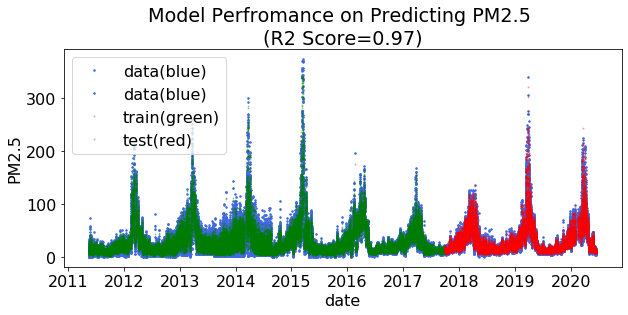

In [7]:
# load data and model 
data = Dataset('Chiang Mai')
data.load_()
pollutant = 'PM2.5'
# load model meta 
with open(data.model_folder + 'model_meta.json') as f:
    model_meta = json.load(f)[pollutant]
    
print(model_meta['rf_score'])

data.x_cols = model_meta['x_cols']
data.fire_dict = model_meta['fire_dict']

# build dataset 
data.feature_no_fire()
data.pollutant = pollutant
data.merge_fire(data.fire_dict)

rf_model = pickle.load(open(data.model_folder +f'PM25_rf_model.pkl','rb'))

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]

xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=data.x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=data.x_cols)

plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,rf_model.predict(xtrn), marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,rf_model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting PM2.5 \n(R2 Score=0.97)')
plt.xlabel('date')
plt.ylabel('PM2.5')

In [15]:
trn_data = data.data.loc[trn_index]
test_data = data.data.loc[test_index]

wea_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)',
       'PM2.5_lag_1', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W',
       'is_rain']

fire_cols = ['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000','PM2.5_lag_1']
# datetime information cols use the data from the test set 
date_cols = ['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day']

wea = trn_data[wea_cols]
fire = trn_data[fire_cols]

In [101]:
n_samples = 1000

year_list = trn_data.index.year.unique()
year_sam = np.arange(len(year_list)) + 1
year_sam = year_sam.cumsum()/year_sam.cumsum().sum()
year_sam = (year_sam*n_samples).astype(int)
year_sam

array([ 11,  35,  71, 119, 178, 250, 333])

In [37]:
# add datetimes columns for weather and fire data for the training data 
wea['year'] = wea.index.year
wea['day_of_year'] = wea.index.dayofyear
wea['hour'] = wea.index.hour

fire['year'] = fire.index.year
fire['day_of_year'] = fire.index.dayofyear
fire['hour'] = fire.index.hour

In [99]:
# pick a date in the test data 
test_datetime = test_data.index[2495]
#get date range
start_date = test_datetime - pd.Timedelta('30 days')
end_date = test_datetime + pd.Timedelta('30 days')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = date_range.dayofyear.to_list()
 
# get hour range 
start_date = test_datetime - pd.Timedelta('1 hours')
end_date = test_datetime + pd.Timedelta('1 hours')
hour_range = pd.date_range(start=start_date, end=end_date, freq='h')
hour_range = hour_range.hour

In [116]:
%%time
year = year_list[-1]
year_sample = year_sam[-1]

# get wether sample 
# select the data
fire_samples = []
wea_samples = []
for year, year_sample in zip(year_list, year_sam):
    # select deata for the year
    wea_sam = wea[(wea['year']==year) & wea['day_of_year'].isin(date_range) & wea['hour'].isin(hour_range)]
     
    if len(wea_sam) > 0:
         wea_samples.append(wea_sam.sample(year_sample,replace=True))
            
    # select deata for the year
    fire_sam = fire[(fire['year']==year) & fire['day_of_year'].isin(date_range) & fire['hour'].isin(hour_range)]
     
    if len(fire_sam) > 0:
         fire_samples.append(fire_sam.sample(year_sample,replace=True))

wea_samples = pd.concat(wea_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)
fire_samples = pd.concat(fire_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)

Wall time: 37.9 ms
